# Rock Climbing Logbook (8a.nu) Analysis
## or: Does Being Tall *Really* Help? <br>
Steve Bachmeier <br>
2019-03-15

In [1]:
# Code to run for report

#----------------------------------------------------------------
# Run the following to hide the In[] and Out[] margin. 
# Doing so will not allow headings to be collapsed.
'''
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
'''

#----------------------------------------------------------------
# Run the following to import required libraries
import dill
import matplotlib.pyplot as plt
import seaborn as sns

#----------------------------------------------------------------
# Run the following to load required pickled objects

df_all = dill.load(open("df_all.pkl", "rb"))
df_results_univariate = dill.load(open("df_results_univariate.pkl", "rb"))

## 1 Synopsis

## 2 Overview

### 2.1 Background

Rock climbing is a tough sport. It takes physical strength, extreme endurance in strange muscle and tendon groups that are not typically targeted (finger ligaments, forearms, etc), dancer-like body awareness and balance (although I am failing hard in this arena!), and serious mental grit. With such obstacles to overcome, then, nothing is more infuriating than when I finally - finally! - successfully complete a climb without falling only to hear such grumblings as: "Ugh, it's so easy if you're tall" or "It's not fair - you can just reach past the difficult holds!"

It's true that with a height of six feet and a +2 so-called ape index (that is, my tip-to-tip arm span is my height plus two inches, ie 6'2") I can sometimes do in one big move what a shorter guy or gal might require two or three. But conversely, and I've argued this adamently for years, there are plenty of times where the next hold is perfectly at arms length for a short person whereas for me it's relatively lower and requires me to scrunch up into all sorts of weird inefficient positions. The more I crunch, the more my butt sticks out, and the farther from the wall my center of gravity goes - it's all physics! That's not even to mention the math behind leverage (where my longer arms are not necessarily an advantage) or the fact that taller people also tend to be heavier. 

So what's the deal? Is it better for climbing to be tall or short? And while we are at it, what about other factors like weight, gender, and years of experience?

### 2.2 Data

The raw data was downloaded from: https://www.kaggle.com/dcohen21/8anu-climbing-logbook.

The data used was scraped from an online logbook, https://beta.8a.nu/, by David Cohen (https://www.kaggle.com/dcohen21). It should be noted that the user's code to scrape the website is no longer avaialable due to DMCA takedown.

Per the data description, it was collected on 2017-9-13. The data is assumed to be accurate.

### 2.2.1 8a.nu description

8a.nu is a rather popular online logbook used to track rock climbs completed. A user creates an account, searches for a specific climb he/she finished, and logs information about it such as its difficulty; whether it was on-sighted (climbed without falling on the first time), flashed (climbed without falling on the first time but after having watched someone else do it), or redpointed it (climbed it without falling after previously failing); how much the liked it based on a 0-3 star rating; and any other notes.

The website also includes details about each climb such as the consensus difficulty grade and rating, location, and type of climb ('rope' refers to taller climbs that are typically done with a harness/rope and belayer and 'boulder' refers to shorter climbs done with no rope).

Finally, user details can be optionally input including things such as gender, height, weight, the year he/she began climbing, etc.

**It is important to note that climbs on 8a.nu are only logged when successfully completed without falling.**

### 2.3 Goal

To determine which - if any - attributes give climbers a statistically significant advantage.

## 3 Data wrangling
This section outlines the data formatting completed. Refer to the Jupyter Notebook analysis.ipynb for entire analysis and code.

### 3.1 Data preparation

The downloaded dataset from came in the form of an SQlite database. Using the Python ```sqlite3``` package, all tables in the database were read into ```pandas``` dataframes and then saved out as csv files. All csv files were then read back into Python into one dictionary which was finally unpacked into separate raw data dataframes; there were in the end four:
* users (62592 rows, 22 columns)
* ascents (~4.1 million rows, 28 columns)
* climbing methods (5 rows, 4 columns)
* climbing grades (83 rows, 14 columns)

Each row in the users dataframe corresponded to a different unqique person and included such information ask user ID, name, location, gender, height, weight, etc.

The ascents dataframe is a log of all of the climbs logged on 8a.nu and includes information like the ascent ID, the user ID of that specific ascent, the method ID, date, notes, etc.

The method dataframe is a small one that includes ony five rows. It's columns consist of method ID, score, shorthand, and name. Shorthand and name are redundant (lower case vs capitalized) and are simply the types of finish a climber can get (redpoint, flash, onsight, and toprope). It's unclear what exactly score is. Note that there is not option for failed attempts (finishing but having fallen at least once in the process).

Finally, the grades dataframe lists all of the current climbing grade possibilities from very easy (grade ID of 0) to world class (grade ID of 82). The grade IDs align one-to-one with the French rating system (0 to 9c+/10a). Other columns are included (including the American Yosemite Decimal System grading system) but the fact that the French grades align completely with the grade IDs implies that grade ID is a good indicator of difficulty. Essentially, it is assumed that climbs become linearly difficult from a grade ID of 0 up to a grade ID of 82.

### 3.2 Data cleaning

With the raw data now in usable dataframes, they can be cleaned. Refer to analysis.ipynb for the code itself.

In summary:

1. Drop unnecessary columns from all four dataframes
2. Check for null/empty values in all dataframes $^{[a]}$
3. For the user dataframe:
  1. Convert the 'sex' variable to dummy variable 'is_female' $^{[b]}$
  2. For the birth years that exist, extract just the year.
  3. Drop any remaining duplicate user IDs.
4. For the ascent dataframe:
  1. Drop any duplicate ascent IDs.
  2. Convert user ID column to integers.

------------
$^{[a]}$ It should be noted that there is a fair amount of null values for the 'birth' feature in the users dataframe; 55.5% of people did not bother putting their birth date into the website. It was decided not to drop the column nor to impute the values; instead, filter as necessary.

$^{[b]}$ The 'sex' variable had three unique values. The vast majority were 0s and 1; four users had sex=255. As I highly doubt that the 8a.nu team has implemented non-binary gender assignment functionality into the website, those four users were simply dropped from the dataset. 

As for the 0s and 1s, it was found that 0s were on average heavier and taller than 1s. Further, there were significantly more 0s than 1s. As most climbers are male and males tend to be taller and heavier than females, the 'sex' category was renamed as 'is_female'. 

------------

### 3.3 Data merge and new feature creation

With cleaned datasets, they can now be merged into one large working dataframe. This is completed by merging the user dataframe onto the ascent dataframe using the user ID primary keys. The columns of the new working dataframe are then rearranged and two new features added: 'age' ('year' - 'birth_year') and 'years_climbed' ('year' - 'started').

With the new 'age' and 'years_climbed' features created, the 'year', 'birth_year', and 'started' columns are no longer of interest and are dropped.

Finally, to clarify some of the column names (and remain consistent), the following labels are renamed:
* 'user_id' to 'id_user'
* 'method_id' to 'id_method'
* 'grade_id' to 'id_grade'
* 'climb_type' to 'is_bouldering' $^{[a]}$

-------------

Notes

$^{[a]}$ The 'climb_type' variable is binary and consists of 0s and 1s. By comparing the climbs with the most 0s and the most 1s (ie the most popular climbs for each 'climb_type') to their descriptions on another popular online log (www.mountainproject.com), it became clear that 'climb_type' = 0 refers to rope climbs and 'climb_type' = 1 refers to bouldering problems. As such, the variable was renamed to 'is_bouldering' to reduce any future confusion.

--------------

### 3.4 Filter data

Recall that there are four different method types (redpoint, flash, onsight, and toprope). For the purposes of this analysis, toprope ascents are not considered successful $^{[a]}$ and so all ascents with an 'id_method' = 4 are dropped from the working dataframe. Then the 'id_method' column is dropped.

At this point the working dataframe consists of ~4 million rows and 9 columns.

--------------

Notes:

$^{[a]}$ Toproping is when a person climbs attached to the rop which goes up to an anchor at the top of the climb and then back down to the belayer. 

--------------

#### 3.4.1 A note about NULL/bogus values

It should be noted here that, despite having cleaned up the data already, NULL and bogus values have been left intact on purpose. Specifically, the date data ('years_climbing' and 'age') is full of NULL values as well as values that simply don't make sense (negatives, 0s, and impossibly large values). Likewise, the weight data includes some 0s and the height data includes values ranging from 0cm tall to 255cm tall. 

All of this data is purposefully left in because to remove them all would drastically reduce the dataset even for variables that are otherwise fine. For example, over 21% of the observations have NULL values for 'age' (as a result of either the original 'year' or 'birth_year' being NULL). However, just because users chose not to input year data does not mean that the rest of their data is bad! As such, the entirety of the dataset is kept intact and the following filters will be applied as necessary:

* 'height': 120-240 cm 
* 'weight': not 0 (equivalent to 40-100 kg)
* 'age': 10-50
* 'years_climbing': 0-40

**Note that these filters are somewhat arbitrary!** There certainly may be climbers in the dataset shorter than 120 cm, taller than 240 cm, with more than 40 years of climbing experience, or out outside the age range of 10-50. However, it is assumed that most users that have these outlier vales are (a) either just that, outliers or (b) simply input incorrect data. 

### 3.5 Reduce

To accurately gage a climber's skill level, it is important not to consider every single grade ever climbed but instead to extract each person's personal best. Much like a world-class sprinter does not always run to beat a record, climbers very often - mostly, really - climb at grades that are below their historical high. As such, the total working dataframe is reduced to only include each user's *oldest* maximum 'id_grade' for both rope climbs and boulder problems.

With the 'id_ascent' column no longer needed for such sorting and grouping, it is dropped.

The head of the working dataframe is shown below.

In [2]:
df_all.head()

,id_user,is_female,height,weight,is_bouldering,id_grade,age,years_climbing
0,1,0,177,73,0,62,25.0,5.0
1,1,0,177,73,1,51,26.0,6.0
2,2,0,0,0,0,49,NaN,1.0
3,2,0,0,0,1,46,NaN,1.0
4,3,0,180,78,0,62,26.0,4.0


### 3.6 Separate data

Recognizing that rope climbing and bouldering are quite different despite both being considered "rock climbing," it was decided to separate the dataset based on 'is_bouldering'. Similarly, the datasets are separated on 'is_female' as well to get different results based on gender. There are thus five different dataframes to be used depending on the analysis at hand:

* df_all (49,598 rows, 8 columns)
* df_bouldering_female (2,396 rows, 6 columns)
* df_bouldering_male (16,817 rows, 6 columns)
* df_rope_female (4,592 rows, 6 columns)
* df_rope_male (25,793 rows, 6 columns)

Note that the four data subsets contain six columns instead of eight like ```df_all```; this is because 'is_female' and 'is_bouldering' are not useful and are dropped.

## 4 Exploratory data analysis
It is always a good idea to do at least a bit of exploratory data analysis before diving too deep into an analysis; it can shed light on trends, potential problems, etc.

### 4.1 Basic statistics

Basic statistics of the ```df_all``` dataframe with all filters discussed above are shown below.

In [3]:
df_all[
    (df_all['height'] >= 120) & (df_all['height'] <= 240) &
    (df_all['weight'] != 0) &
    (df_all['age'] >= 10) & (df_all['age'] <= 50) &
    (df_all['years_climbing'] >= 0) & (df_all['years_climbing'] <= 40)
].describe()

,id_user,is_female,height,weight,is_bouldering,id_grade,age,years_climbing
count,21370.000000,21370.000000,21370.000000,21370.000000,21370.000000,21370.000000,21370.000000,21370.000000
mean,28426.796678,0.110014,176.283528,68.000608,0.400796,53.389705,26.866589,6.791624
std,18047.372392,0.312915,8.722877,9.928711,0.490071,9.682915,6.924253,5.703908
min,1.000000,0.000000,120.000000,40.000000,0.000000,1.000000,10.000000,0.000000
25%,13441.000000,0.000000,172.000000,63.000000,0.000000,49.000000,22.000000,3.000000
50%,26109.500000,0.000000,177.000000,68.000000,0.000000,55.000000,26.000000,5.000000
75%,41793.000000,0.000000,182.000000,73.000000,1.000000,62.000000,31.000000,9.000000
max,67022.000000,1.000000,228.000000,100.000000,1.000000,83.000000,50.000000,40.000000


Of particular interest is perhaps the values for mean. From the table we see that the average climber in the 8a.nu database (for both genders and both types of climbing)  is ~176 cm (~5' 9.3") tall, weighs 68 kg (150 lbs), and climbs at a grade of ~53 (which corresponds to 7b on the French grading system and 12b on the Yosemite Decimal System) after 6.8 years of climbing. Also, the average values for 'is_female' and 'is_bouldering', being binary dummy variables, can be interpreted as 11% of the users are female and 40% of the ascents are boulders.

It should be noted that an average best climbing grade if 7b is quite respectable. It can take many years of consistent climbing to get to that level. It is thus clear that users of 8a.nu tend to be quite accomplished rock climbers and this should be kept in mind when interpreting results.

### 4.1 Pairplot

Pairplots can be quite useful at shedding light on correlations between the variables of a given dataset.

C:\Users\steve\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


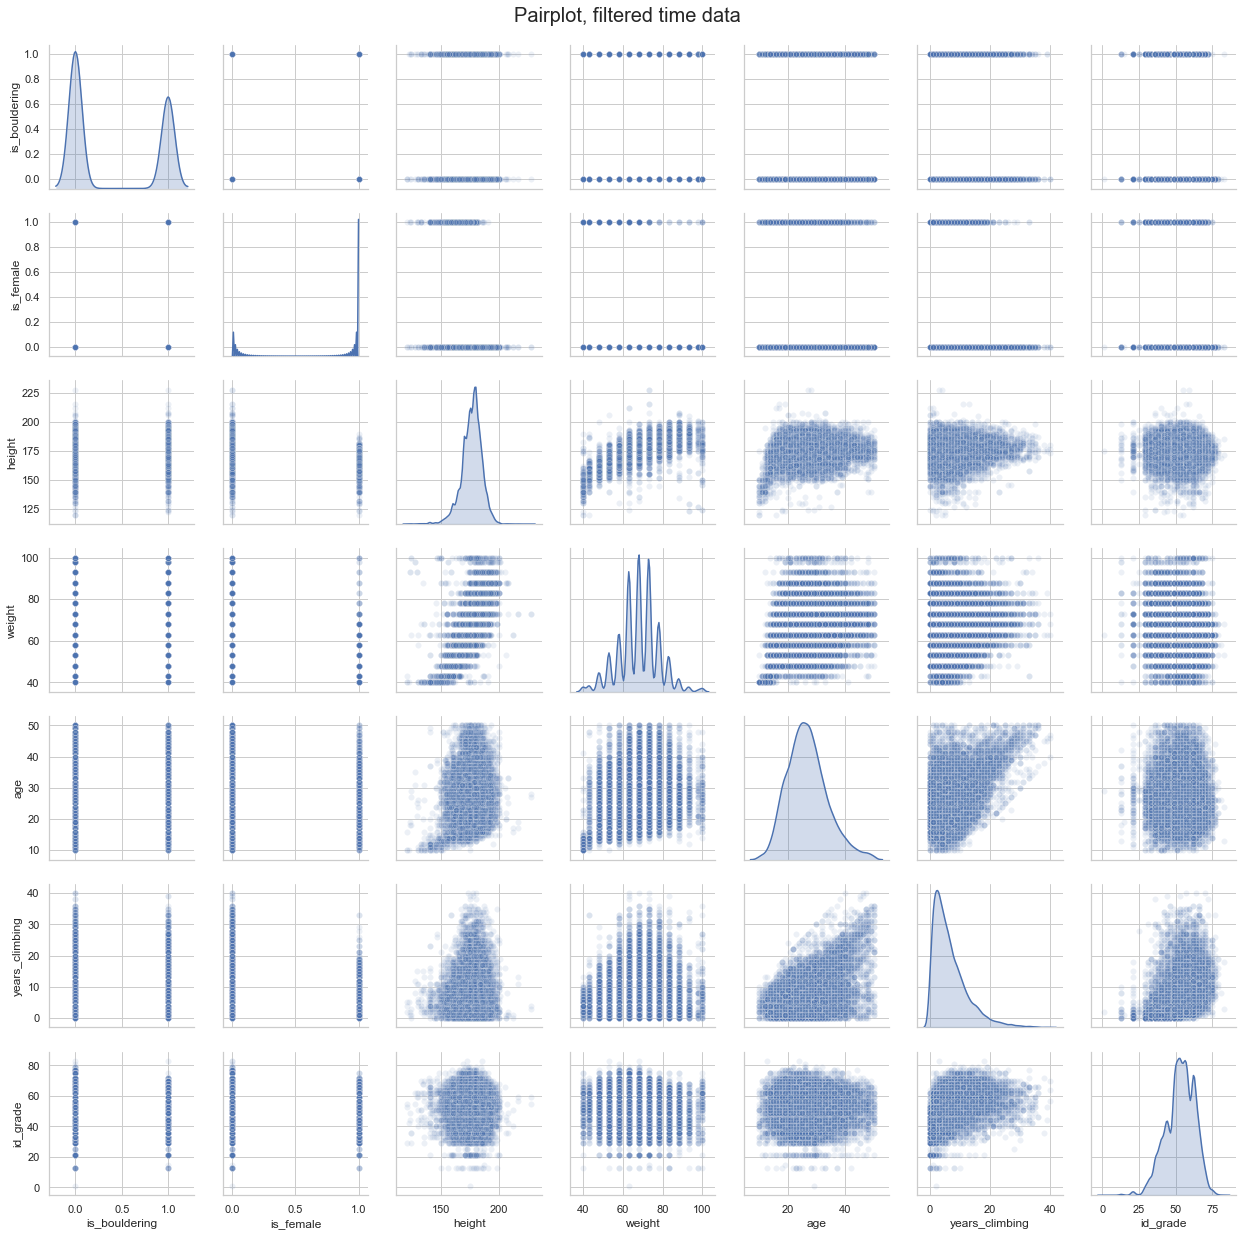

In [6]:
%matplotlib inline

sns.set(style="whitegrid")
g = sns.pairplot(df_all[
    (df_all['height'] >= 120) & (df_all['height'] <= 240) &
    (df_all['weight'] != 0) & 
    (df_all['age'] >= 10) & (df_all['age'] <= 50) & 
    (df_all['years_climbing'] >= 0) & (df_all['years_climbing'] <= 40)]\
                 [['is_bouldering','is_female','height','weight','age','years_climbing','id_grade']], 
                 diag_kind='kde', dropna=True, plot_kws={'alpha':0.1})
g.fig.suptitle("Pairplot, filtered time data", size=20)
plt.subplots_adjust(top=0.95)

Several interesting points are highlighted by the above pairplot. Regarding the distribtuions of the features (as shown in the KDE plots along the diagonal):

* Height and weight are qualitatively normally distributed.
* Age is mostly normally distributed with perhaps a very light right skew.
* Years climbing is clearly right skewed. This makes sense since most people do not spend many, many years rock climbing (or playing any sport for that matter).
* The max grade distribution appears to be slightly left skewed.

Pairplot are particularly useful for comparing one feature against another. For example, weight and height seem to have a positive correlation with one another (which can be expected). Also not surprising is that there is a positive correlation with age and the number of years climbing.

Interestingly, aside from 'years_climbing', there does not seem to be any features that are obviously correlated with 'id_grade'.

### 4.2 Average 'id_grade' vs 'height'

Scatter plots of average 'id_grade' as a function of height for both genders and both climbing types are shown below; the sizes of the points correspond to the number of users at a given grade and height. Interestingly, the maximum climbing grades in the dataset are not linearly correlated with height. Instead, the data appears mostly parabolic where the highest grades are obtained by climbers in the middle of the height range; shorter and taller climbers seem unable to reach the same level of ability.

Note that confounding variables and multicollinearity must always be considered before making conclusions. For example, it's entirely possible (and indeed hinted at in the above pairplot) that height and weight are correlated; care must be taken then to make broad conclusions about the affects of height on climbing ability until further statistical analyses are completed. 

<img src='images/fig_scatter_grade_vs_height.png' style='width: 80%;'/>

### 4.2 Average 'id_grade' vs 'weight'

Scatter plots of average 'id_grade' as a function of weight for both genders and both climbing types are shown below; the sizes of the points correspond to the number of users at a given grade and weight. For males, weight seems to interact with maximum climbing grade similarly to how heights do (see above section) - there is a sort of parabolic trend. For females, however, the trends are not so clear. 

It should be noted that, like height, there may be other confounding or highly correlated variables tied to weight. For example, it might seem like the heavier a climber is, the less successful he/she will become. However, if that increased weight is due to muscle mass instead of fat mass, then it is entirely possible that a heavy climber becomes very accomplished.

<img src='images/fig_scatter_grade_vs_weight.png' style='width: 80%;'/>

### 4.3 Average 'id_grade' vs 'age'

Scatter plots of average 'id_grade' as a function of age for both genders and both climbing types are shown below; the sizes of the points correspond to the number of users at a given grade and age. Somewhat similar to the trends above, the affects of age on males seem to be parabolic where the hardest climbing grades occur towards the middle of the age range. The affects on females, however, is not as clear.

It does make sense that very young climbers are unable to climb as well as older climbers - height, strength, and available time are not necessarily in children's favor. It also makes sense that grades tend to drop off towards the higher ages; this may simply be due to the affects of aging on the body.

<img src='images/fig_scatter_grade_vs_age.png' style='width: 80%;'/>

### 4.4 Average 'id_grade' vs 'years_climbing'

Scatter plots of average 'id_grade' as a function of years climbing for both genders and both climbing types are shown below; the sizes of the points correspond to the number of users at a given grade and years. Unsurprisingly, the maximum grade increases with the number of years - but only up to a certain point. Especially for males, the grades seem to drop as climbers become very experienced. Perhaps this is due to the effects of age since 'years_climbing' and 'age' are more than likely highly correlated.

<img src='images/fig_scatter_grade_vs_years_climbing.png' style='width: 80%;'/>

## 5 Analysis

The plots shown above suggest that there are not blatantly obvious correlations between a person's rock climbing ability and his/her height, weight, age, or years of experience. The goal here is then to fit various linear regression models to determine whether inferences can be made. For all analyses, a significance level of 0.05 is used and so a P-value <= 0.05 implies that the null hypothesis that no change in the dependent variable ('id_grade') should occur for a unit change in the independent variable (ie the coefficient - or slope - is zero) is rejected. In other words, the calculated results are considered statistically significant if the corresponding P-values <= 0.05.

### 5.1 Discussion - ordinary least squares method

For the analyses below, Python's ```statsmodels``` package is used. Models are fit using the ordinary least squares ```.ols()``` method which takes the form 

$y_{i} = \beta_{0} + \beta_{1}x_{i1} + \beta_{2}x_{i2} + ... + \beta_{n}x_{in} + \epsilon_{i}$,

where i represents each observation (row in the dataset), $y_{i}$ are the dependent variables (eg 'id_grade'), $x_{i}$ are independent variables (eg 'height', 'weight', etc), n is the number of independent variables, $\epsilon_{i}$ are the errors at each observation, and $\beta_{i}$ are the coefficients to be solved for. The algorithm creates a best fit that minimizes the residuals, ie forces the sum of the residuals to zero.

#### 5.1.1 Required assumptions

The assumptions for this type of method to mathematically work are:

* The model is linear in parameters. That is, the coefficient parameters $\beta_{i}$ are linear.
* The sum of the residuals must equal zero.
* There is no multicollinearity. That is, none of the variables are perfectly correlated with each other.
* There is random sampling of the observations.

The first two assumptions are essentially how the algorithm itself works. Regardless of whether the data is linear in parameters, the program will treat them like they are. Likewise, the model will be fit such that the sum of the residuals is zero. Whether accurate or not, a solution will be found! The third assumption (no multicollinearity) is a mathematical requirement for the algorithm to find a solution.

As for the fourth assumption - it's not needed for the algorithm to run but it is necessary for the underlying statistics to hold. Unfortunately, the 8a.nu dataset is probably not a random sampling of all climbers. For example, it only sampled from climbers who have access to the internet. Also - and this is just a hunch - it probably samples moreso from younger climbers than older ones. Still, it can be useful to derive results as long as it's understood that they apply to 8a.nu users rather than the climbing population as a whole.

#### 5.1.2 Assumptions for quality results

Once the models are fit, the questions becomes whether or not the results trusted. Some of the assumptions made in this regard are:

* The residuals are identically and independently distributed (iid).
  - In addition, for small samples, the residuals are also normally distributed.
* None of the variables are highly correlate with each other.
* The residuals are not correlated with any of the independent variables.
* The residuals do not predict other residuals.
* The residuals are homoskedastic; that is, they have a constant variance.

So how can we determine whether the above assumptions hold true? 

* This is a rather large dataset so normal distribution of the residuals is probably not necessary. Still, QQ plots are used to qualitatively assess residual normality.
* Consider dropping any independent variables that are highly correlated with each other. The threshold for a high correlation is somewhat arbitrarily set at 0.5 for this analysis.
  - Also consider the variable inflation factor (VIF) - in addition to correlation factor - before dropping. The threshold for a high VIF is arbitrarily set to 2 for this analysis.
* Ensure that the sum of the residuals = 0.
* Ensure that the mean of the residuals = 0.
* Create a scatterplot of the residuals as a function of the independent variables.
  - The points should appear random and be scattered about the horizontal axis for residual = 0.
    - If any patterns are present it may be an indication of high variable correlation.
    - If the residuals get larger or smaller as a function of the variable then it indicates heteroskedasticity.


### 5.2 Univariate analyses

Let's first get a sense of any linear trends found by comparing the dependent variable ('id_grade') against each independent variable separately for all four categories (bouldering female, bouldering male, rope female, and rope male). Note that caution must be used when making conclusions from univariate results since often is that case that an outcome truly does depend on more than a single other independent variable. Further, confounding variables can lead to erroneous conclusions.

As an example, a scatterplot of 'id_grade' vs height is plotted for each category along with the corresponding linear regression lines below. Refer to the analysis notebook for the same plots for 'weight', 'age', and 'years_climbing'. 

<img src='images/fig_lm_grade_vs_height.png' style="width: 80%;"/>

Interestingly, in all four cases, the linear regression appears to have a negative slope. Notice also that the 95% confidence interval bands are a bit larger for females than for males.

The ```ols()``` method in the ```statsmodels``` package is now used to extract the coefficients, standard errors, and P-values; see the summary table below.

In [9]:
df_results_univariate[df_results_univariate['Variable'] == 'Height (cm)']

,Variable,Type,Gender,Coefficient,Std_error,P_value,Statistically_significant
0,Height (cm),Bouldering,F,-0.059,0.030,0.050,Yes
1,Height (cm),Bouldering,M,-0.079,0.010,0.000,Yes
2,Height (cm),Rope,F,-0.050,0.026,0.056,No
3,Height (cm),Rope,M,-0.106,0.010,0.000,Yes


In all cases, the coefficient is negative. The P-values for males are both zero while the P-value for females bouldering is right at the significance level of 0.05 and the P-value for females rope climbing is just a hair above the significance level at 0.056. The following statements can made: 

* For every cm a female has in height, her best bouldering grade is expected to decrease by 0.059.
* For every cm a male has in height, his best bouldering grade is expected to decrease by 0.079.
* A female's best rope climbing grade as a function of height is not statistically significant.
* For every cm a male has in height, his best rope climbing grade is expected to decrease by 0.106.

Again, however, confounding variable can be at play and conclusions must wait until multivariate analyses have been considered.

The assumptions made for this analysis are checked by ensuring that the residuals have a mean of 0 and a sum of 0 (they do) and that they are scattered in a qualitatively random fashion about the x-axis. All four residual scatterplots are shown below and indeed no significant patterns appear to exist.

<img src='images/fig_scatter_residuals_grade_vs_height.png' style="width: 80%;"/>

To check that the residuals are normally distributed (again, this is not necessarily a requirement for large datasets), one can inspect qualitatively the so-called quantile-quantile (QQ) plots. These plot the sample quantiles as a function of the theoretical quantiles. The more this scatterplot looks like the ideal 45-degree line (shown in red), the more normally distributed the samples are.

<img src='images/fig_qq_grade_vs_height.png' style="width: 80%;"/>

Although this is a strictly qualitative approach, it is a useful one. All four plots show a somewhat normal distribution around the center but then they markers drop off at both ends; this imiplies that the residuals are left-skewed. To check, the residual histograms are shown below.

<img src='images/fig_histogram_residuals_grade_vs_height.png' style="width: 80%;"/>

Indeed, the histograms seem to be mostly normal with a left skew. Although not completely ideal, the datasets used are rather large and so such deviations from ideal are assumed to be acceptable.

For brevity's sake, these plots are not shown for the other three independent variables of interest ('weight', 'age', and 'years_climbing'); refer to the analysis notebook if interested. Needless to say, similar results were found with the exception of the residuals plot for the 'years_climbing' variable which appears to have a bit of a pattern to it; see below. This implies that the errors can be somewhat predicted by 'years_climbing' and may suggest that the linear model fit is not appropriate.

<img src='images/fig_scatter_residuals_grade_vs_years_climbing.png' style="width: 80%;"/>

The results of all independent variables are shown below.

In [5]:
df_results_univariate

,Variable,Type,Gender,Coefficient,Std_error,P_value,Statistically_significant
0,Height (cm),Bouldering,F,-0.059,0.030,0.050,Yes
1,Height (cm),Bouldering,M,-0.079,0.010,0.000,Yes
2,Height (cm),Rope,F,-0.050,0.026,0.056,No
3,Height (cm),Rope,M,-0.106,0.010,0.000,Yes
4,Weight (kg),Bouldering,F,-0.068,0.030,0.024,Yes
5,Weight (kg),Bouldering,M,-0.139,0.009,0.000,Yes
6,Weight (kg),Rope,F,-0.111,0.027,0.000,Yes
7,Weight (kg),Rope,M,-0.202,0.008,0.000,Yes
8,Age,Bouldering,F,-0.025,0.033,0.448,No
9,Age,Bouldering,M,-0.073,0.012,0.000,Yes


Perhaps surprisingly, all of the coefficients for climbing grade as a function of height and weight (independently) are negative; for those cases that are significantly significant (that is, the P-value <= 0.05), this means that on average being taller or heavier results in a worse personal highesst climbing grade! 

On the other hand - and not surprisingly - climbing grade as a function of years climbing is positive (and statistically significant for all four cases). Age, however, is not a significant influencer on climbing grade except for males bouldering in which case it is negatively correlated.

Finally, for both bouldering and rope climbing, the grade vs. gender variable ('is_female') is negative; this can be interpreted as females on average climb at lower grades than males. 

It is incredibly important to remember that these findings are the results of a *univariate* analysis where the maximum climbing grades were fit with a linear model assuming it is a function of only a single variable at a time - conclusions must not be drawing until a full multivariate analysis is completed and fleshed out enough to be trusted.

### 5.3 Multivariate analyses

The above univariate analysis is useful for understanding how the outcome (ie 'id_grade') behaves as a function of a single independent variable at a time. In reality, however, it may very well be that a *better* model can be fit - still using ordinary least squares regression - by accounting for more than one feature at a time. 

#### 5.3.1 Variable reduction

It's not an uncommon phenomenon that seemingly different variables are strongly related to one another and including both in a model can lead to incorrect results. It's thus important to reduce the variables included in the model to only those that are not strongly correlated with one another. For the sake of this analysis the correlation threshold is 0.5.

Another test for multicollinearity is the variable inflation factor (VIF). The threshold VIF for this analysis is 2.

-------------

An aside:
Note this is somewhat different than the problems caused by confounding variables which are variables not accounted for in the model that may be the true cause of an effect; they are one reason why it's always important to remember that correlation is not the same as causation. A fun example of confounding variables are the studies that show a correlation between the number of people drowning and ice cream sales. Could eating ice cream really cause a statistically significant increase in drownings? While the old wive's tale may blame it on the now-deceased ice cream eaters not waiting 30 minutes before going for a swim, in reality, the confounding variable - and the presumably *true* reason for the correlation - is nothing more than the outside temperature. As the temperature increases, so does the amount of ice cream consumed as well as the number of people who swim.

---------------

The correlation matrix for the data at hand is shown below. Note that all variable filters have been set.

### 5.4 Discussion of results

## 6 Suggestions for improvement

Some recommendations to improve this analysis include:

* Explore and account for any outliers that exist.
* Consider applying linear fits to non-linear variables. This may be especially useful for those variables that seem to result in the maximum climbing grade having a somewhat parabolic shape (ie height and weight).
  - Note that a linear fit only assumes that the model is linear with respect to the coefficients $\beta_{in}$ - it says nothing about the variables themselves which may indeed be transformed, eg $y_{i} = \beta_{0} + \beta_{1}x_{i1}^{2} + \beta_{2}x_{i2}^{2} + ... + \beta_{n}x_{in}^{2} + \epsilon_{i}$.
* It might be interesting to perform a principal component analysis. This would result in loss of interpretability of the variables, but some insight might be made by looking at the most important variables to the principal components.
* Use datetime information instead of simply extracting the years to get more accurate age and years_climbing data.
* Explore the *rate* at which each user progresses by considering time series data.
* User more data! Users of 8a.nu tend to be rather strong climbers and so this analysis leans very much towards those who have made rock climbing a significant part of their life. It therefore may not be appropriate to draw conclusons about more casual rock climbers.
